# Diabetes prediction: A Comparative Analysis of Classification Models
- K Srikar Goud
- NJIT UCID: Sk3772

## Importing Libararies

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load and Preprocess Data

In [19]:
# Load the dataset
dataset = pd.read_csv('diabetes_prediction_dataset.csv')
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

In [21]:
# Encode categorical features
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

# One-hot encoding for a categorical column
ct = ColumnTransformer(transformers=[('Encoding', OneHotEncoder(), [4])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [23]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [25]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM model
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define LSTM Model

In [46]:
"""def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    lstm_model.add(Dense(units=1, activation='sigmoid'))
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return lstm_model"""
from keras.layers import Input

# Initialize LSTM model
def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(X_train_reshaped.shape[1], 1)))
    lstm_model.add(LSTM(units=50, activation='relu'))
    lstm_model.add(Dense(units=1, activation='sigmoid'))
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return lstm_model


# Define Classifiers and K-Fold Cross-Validation

Text(0.5, 1.0, 'ROC Curve')

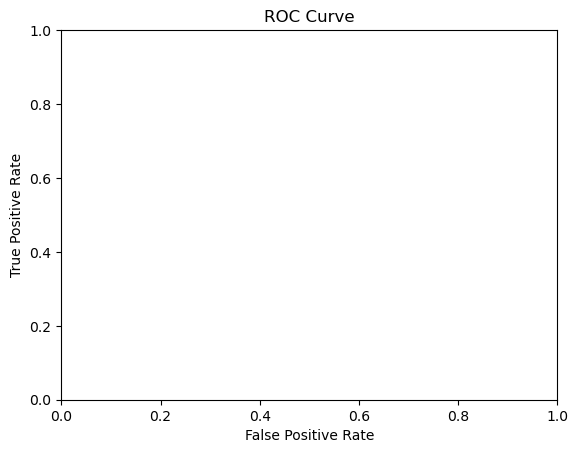

In [49]:
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'LSTM': create_lstm_model()
}

# Initialize KFold with 5 folds (you can adjust as needed)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Initialize a list to store fold-wise metrics
fold_metrics = []
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


# Perform Cross-Validation and Calculate Metrics



Evaluating Random Forest...
Evaluating K-Nearest Neighbors...
Evaluating LSTM...
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


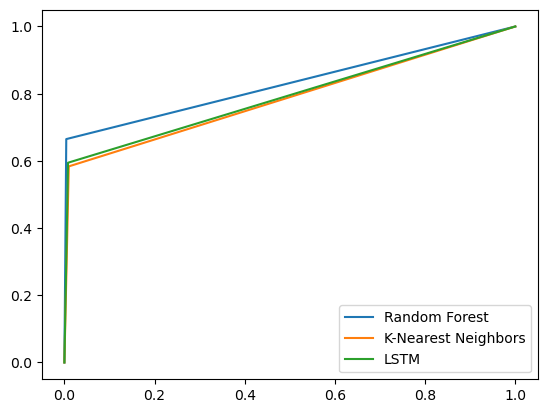

In [52]:
# Perform KFold cross-validation for each classifier
for clf_name, clf in classifiers.items():
    print(f"Evaluating {clf_name}...")
    accuracy_values = []
    precision_values = []
    tp_values = []
    tn_values = []
    fp_values = []
    fn_values = []
    tpr_values = []
    tnr_values = []
    npv_values = []
    fpr_values = []
    fdr_values = []
    fnr_values = []
    f1_values = []
    bacc_values = []
    tss_values = []
    hss_values = []
    bs_values = []
    bss_values = []

    for fold_no, (train_index, test_index) in enumerate(kf.split(X_train_scaled), 1):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[test_index]

        if clf_name != 'LSTM':
            # Fit classifier to training fold
            clf.fit(X_train_fold, Y_train_fold)

            # Predict labels on validation fold
            Y_pred_fold = clf.predict(X_val_fold)
        else:
            # Create a new instance of LSTM model for each fold
            lstm_model = create_lstm_model()

            # Fit LSTM model to training fold
            lstm_model.fit(X_train_reshaped[train_index], Y_train_fold, epochs=1, batch_size=32, verbose=0)

            # Predict labels on validation fold
            Y_pred_fold = (lstm_model.predict(X_train_reshaped[test_index]) > 0.5).astype("int32").flatten()

        # Calculate performance metrics
        tp = np.sum((Y_pred_fold == 1) & (Y_val_fold == 1))
        tn = np.sum((Y_pred_fold == 0) & (Y_val_fold == 0))
        fp = np.sum((Y_pred_fold == 1) & (Y_val_fold == 0))
        fn = np.sum((Y_pred_fold == 0) & (Y_val_fold == 1))
        acc = (tp + tn) / (tp + fp + tn + fn)
        ppv = tp / (tp + fp)
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        npv = tn / (tn + fn)
        fpr = fp / (fp + tn)
        fdr = fp / (fp + tp)
        fnr = fn / (fn + tp)
        f1 = 2 * tp / (2 * tp + fp + fn)
        bacc = (tpr + tnr) / 2
        tss = tp / (tp + fn)
        hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
        bs = np.mean((Y_pred_fold - Y_val_fold) ** 2)
        reference_forecast = np.mean(Y_val_fold)
        bss = 1 - (bs / reference_forecast)

        # Append metrics for current fold
        fold_metrics.append({
            'Classifier': clf_name,
            'Fold': fold_no,
            'True Positives': tp,
            'True Negatives': tn,
            'False Positives': fp,
            'False Negatives': fn,
            'Accuracy': round(acc * 100, 2),
            'Precision': round(ppv * 100, 2),
            'Sensitivity': round(tpr * 100, 2),
            'Specificity': round(tnr * 100, 2),
            'Negative Predictive Value': round(npv * 100, 2),
            'False Positive Rate': round(fpr * 100, 2),
            'False Discovery Rate': round(fdr * 100, 2),
            'False Negative Rate': round(fnr * 100, 2),
            'F1 Score': round(f1 * 100, 2),
            'Balanced Accuracy': round(bacc * 100, 2),
            'True Skill Statistics': round(tss * 100, 2),
            'Heidke Skill Score': round(hss * 100, 2),
            'Brier Score': bs,
            'Brier Skill Score': bss
        })

    # Plot ROC curve
    fpr2, tpr2, thresholds = roc_curve(Y_val_fold, Y_pred_fold)
    plt.plot(fpr2, tpr2, label=f'{clf_name}')
    plt.legend(loc="lower right")


# Display Metrics and Save to CSV

In [55]:
plt.show()

# Save metrics to CSV
metrics_df = pd.DataFrame(fold_metrics)
print(metrics_df)
csv_file = 'output.csv'
if os.path.exists(csv_file):
    os.remove(csv_file)
metrics_df.to_csv(csv_file, index=False)


             Classifier  Fold  True Positives  True Negatives  \
0         Random Forest     1             867           13723   
1         Random Forest     2             885           13625   
2         Random Forest     3             862           13692   
3         Random Forest     4             918           13670   
4         Random Forest     5             851           13663   
5   K-Nearest Neighbors     1             771           13654   
6   K-Nearest Neighbors     2             774           13570   
7   K-Nearest Neighbors     3             764           13637   
8   K-Nearest Neighbors     4             821           13599   
9   K-Nearest Neighbors     5             747           13587   
10                 LSTM     1             768           13680   
11                 LSTM     2             793           13597   
12                 LSTM     3             678           13708   
13                 LSTM     4             734           13653   
14                 LSTM  